In [1]:
## This allows us to import from the folder above this one:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import electrode2currentmap as e2cm
import effectivecurrent2brightness as ec2b
from scipy import interpolate
from utils import TimeSeries
import matplotlib.pyplot as plt
from itertools import product
import utils
import time
import string
import scipy
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# We'll use skimage for file io:
import skimage.io as skio

In [4]:
# Initalize a retina object:
x = 3200
y = 2500
r = e2cm.Retina(axon_map='../retina_2500by3200_lambda4.npz',
                sampling=25, ylo=-y, yhi=y, xlo=-x, xhi=x, axon_lambda=4)

In [5]:
# equally spaced electrodes
e_spacing = 525

# x-pos, y-pos, radius, height
x_arr = np.arange(-2362, 2364, e_spacing)
y_arr = np.arange(-1312, 1314, e_spacing)
r_arr = np.ones(x_arr.shape)*100
h_arr = np.ones(x_arr.shape)*500

e_all = e2cm.ElectrodeArray(r_arr.tolist(), x_arr.tolist(), y_arr.tolist(), h_arr.tolist())

In [6]:
# We derive the effective current stimulation (ecs; passed through the effect of the retinal layout, axons, etc.) 
# in addition to the current (cs):
ecs, cs  = r.electrode_ecs(e_all)

In [7]:
# Each electrode has its RF in the image, we collect all of these:
e_rf=[]
for e in e_all.electrodes:
    e_rf.append(e2cm.receptive_field(e, r.gridx, r.gridy, e_spacing))
    
# We think of this as a movie with 30 FPS:
fps = 30

# The temporal model contains the cascade of operations that leads from pulse to percept:
tm1 = ec2b.TemporalModel()

KeyboardInterrupt: 

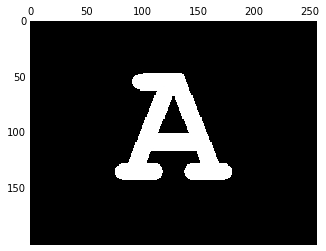

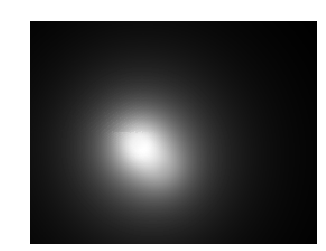

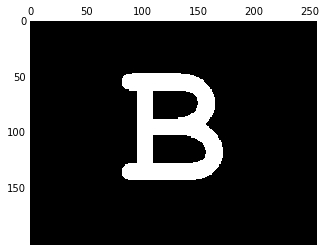

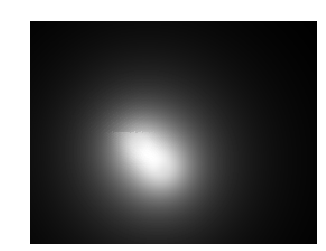

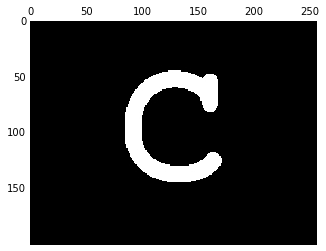

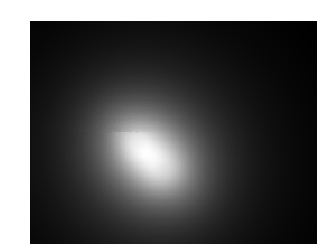

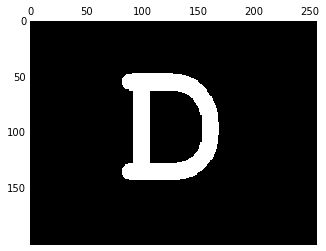

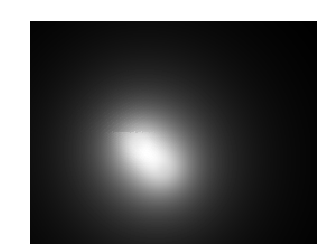

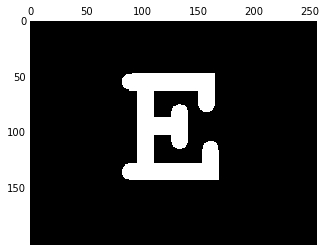

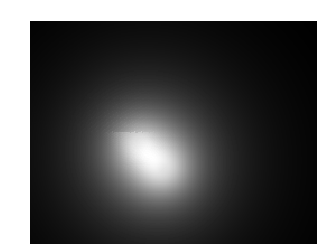

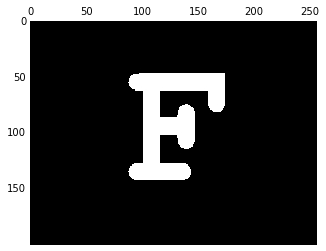

In [8]:
# Looping over all letters (this takes time!)
for letter in string.ascii_uppercase:
    # This inverts the polarity, you might not need it:
    eyechart = (255 - skio.imread('./letters/%s.jpg'%letter)) / 255.
    plt.matshow(eyechart, cmap='gray')
    # This creates a "movie" with two frames (just a hack!)
    frames = np.concatenate([eyechart[..., np.newaxis], eyechart[..., np.newaxis]],-1)
    # The pulse trains:
    pt=[]
    for rf in e_rf:
        #The luminance in each receptive field:
        rflum = e2cm.retinalmovie2electrodtimeseries(rf, frames)
        #plt.plot(rflum)
        # Generate a pulse-train given the luminance in this RF:
        ptrain = e2cm.Movie2Pulsetrain(rflum, amp_max=50)
        #plt.plot(ptrain.data)
        # We store these as we go along:
        pt.append(ptrain)

    rs=1/(fps*pt[0].tsample)  
    # This is where the action happens -- the pulses are converted to a brightness movie
    # using the temporal model cascade:
    brightness_movie = ec2b.pulse2percept(tm1, ecs, r, pt,
                                          int(rs), n_jobs=8, dojit=False, tol=.01)

    fig, ax = plt.subplots(1)
    ax.matshow(brightness_movie.data[:, :, 6], cmap='gray')
    ax.set_axis_off()
    fig.savefig("white_%s_percept.png"%letter)